In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
#jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)
#jax.config.update('jax_disable_jit', True)
#jax.config.update('jax_debug_nans', True)

import jax.numpy as jnp
import matplotlib.pyplot as plt
import tornadox

from pof.solve import get_solver_iterator

In [13]:
ivp = tornadox.ivp.vanderpol_julia(stiffness_constant=1e0, tmax=512)
ivp.y0.device()

GpuDevice(id=0, process_index=0)

In [14]:
dt = 1e-2
order = 3

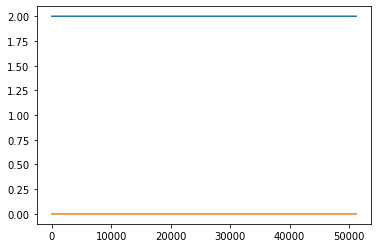

In [15]:
init_state, refine, project = get_solver_iterator(ivp, order=order, dt=dt, parallel=False)
plt.plot(project(init_state))

In [16]:
refine_jit_cpu = jax.jit(refine, backend="cpu")

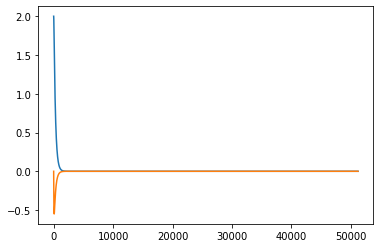

In [17]:
state = init_state
for _ in range(1):
    state = refine_jit_cpu(state)
plt.plot(project(state))

# Benchmarks

Sequential filter on CPU:

In [18]:
%%timeit
refine_jit_cpu(state).mean.block_until_ready()
# note that this number might even include moving data to the cpu

2.26 s ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Parallel filter on GPU: First create the GPU-jitted parallel filter function.

In [19]:
# Create the parallel filter, and define the jitted version
_, refine_par, _ = get_solver_iterator(ivp, order=order, dt=dt, parallel=True)
refine_par_jit_gpu = jax.jit(refine_par, backend="gpu") #

Run it once to jit it:

In [20]:
%%time
refine_par_jit_gpu(state).mean.block_until_ready(); # run once to jit

CPU times: user 13min 25s, sys: 5.53 s, total: 13min 31s
Wall time: 12min 29s


DeviceArray([[ 1.20000000e+08,  0.00000000e+00, -2.00000000e+03, ...,
              -4.00000000e+05,  6.00000000e+03, -1.60000000e+02],
             [ 1.19991815e+08, -3.93215021e+03, -6.68059513e+03, ...,
              -3.88178414e+05,  1.27543284e+04,  6.87421976e+04],
             [ 1.19961890e+08, -7.70079080e+03,  5.69670501e+02, ...,
              -3.76790220e+05,  3.07764824e+03,  8.50532127e+04],
             ...,
             [-5.95796690e-17, -3.67939643e-19, -8.46707090e-22, ...,
              -1.69340746e-19,  9.92992997e-22,  1.83943740e-23],
             [-6.06860181e-17, -3.69623059e-19, -8.36673314e-22, ...,
              -1.67336332e-19,  1.01143735e-21,  1.84888451e-23],
             [-6.17973871e-17, -3.71286246e-19, -8.26507131e-22, ...,
              -1.65294956e-19,  1.02994197e-21,  1.85098439e-23]],            dtype=float64)

Actual benchmark:

In [21]:
%%timeit
refine_par_jit_gpu(state).mean.block_until_ready() #benchmark

668 ms ± 2.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
